In [28]:
import pandas as pd
import scipy as sc
import matplotlib.pyplot as plt
import numpy as np
import datetime as dt


#failure_test = pd.read_csv(r'Failure_modelling\Failure_Data\failure_data.csv', index_col=0)
#pipe_test= pd.read_csv(r'Failure_modelling\Failure_Data\pipe_data.csv', index_col=0)
failure_train = pd.read_csv(r'Failure_modelling\Failure_Data\failure_train.csv', index_col=0)
pipe_train = pd.read_csv(r'Failure_modelling\Failure_Data\pipes_train.csv', index_col=0)

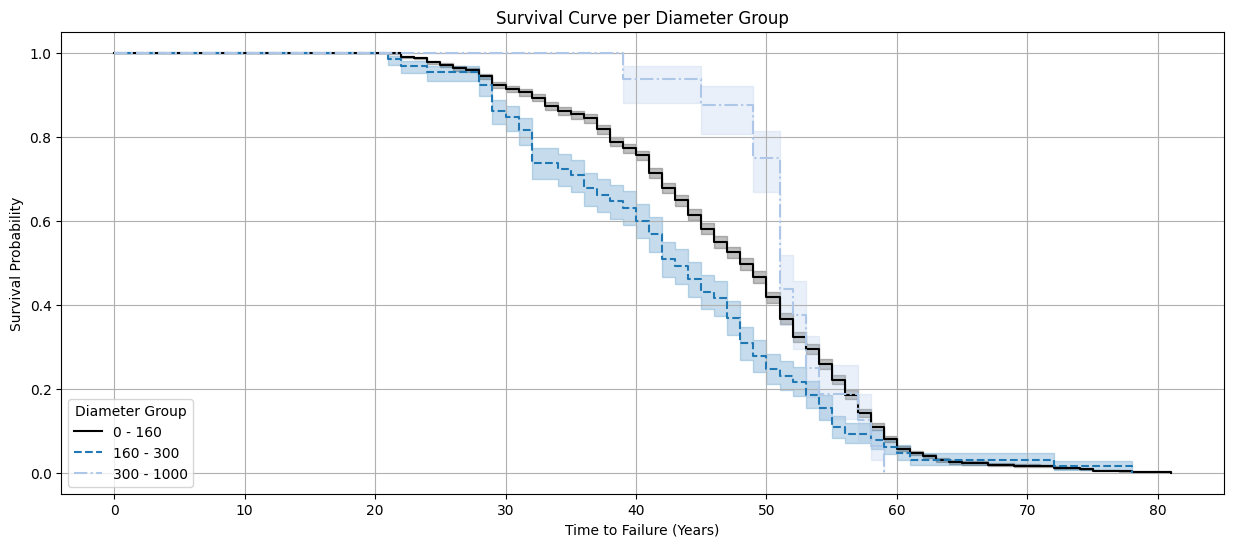

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter
from itertools import cycle

# Define colors and line styles
colors = [
    '#000000', '#1f77b4', '#aec7e8', '#17becf', '#9edae5', 
    '#2ca02c', '#98df8a', '#bcbd22', '#ffbb78', '#ff7f0e', 
    '#d62728', '#ff9896', '#e377c2', '#9467bd', '#c5b0d5', 
    '#8c564b', '#7f7f7f'
]
line_styles = ['-', '--', '-.', ':']

# Create a cycle iterator for both colors and line styles
color_cycle = cycle(colors)
line_style_cycle = cycle(line_styles)

# Sample data for fitting Kaplan-Meier model (replace with your actual data)
failures = failure_train

# Fit and plot the Kaplan-Meier survival curves
kmf = KaplanMeierFitter()
plt.figure(figsize=(15,6))
survival_functions = {}

for diameter, group in failures.groupby('Diameter_group'):
    kmf.fit(group['age_at_failure'], event_observed=(group['storing_melddatum'].notnull()), label=str(diameter), alpha=0.5)
    color = next(color_cycle)
    line_style = next(line_style_cycle)
    kmf.plot(color=color, linestyle=line_style, label=str(diameter))
    survival_functions[diameter] = kmf.survival_function_

plt.title('Survival Curve per Diameter Group')
plt.xlabel('Time to Failure (Years)')
plt.ylabel('Survival Probability')
plt.grid()
plt.legend(loc=3, title='Diameter Group')
plt.show()
# ax.legend(title='Diameter Group')

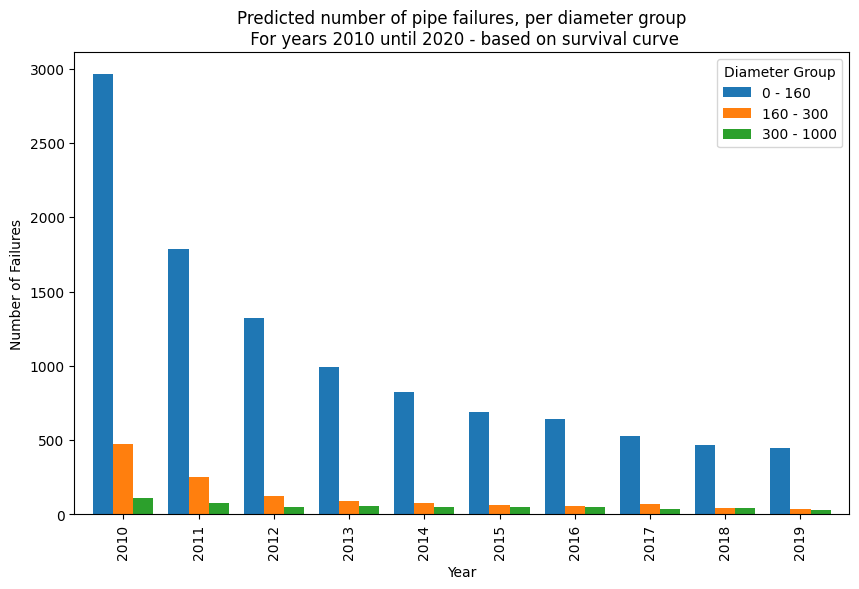

In [35]:
# Assuming survival_functions and pipes are already defined

# Initialize a dictionary to hold failure counts for each key
failure_counts_dict = {}

for key in survival_functions.keys():
    survival_function_df = survival_functions[key]
    pipes_df = pipe_train[pipe_train.Diameter_group == key]

    # Initialize a dictionary to count failures by year
    failure_counts = {year: 0 for year in range(2010, 2020)}

    # Function to interpolate survival probability
    def get_survival_probability(t, survival_df):
        if t in survival_df.index:
            return survival_df.loc[t, key]
        else:
            return np.interp(t, survival_df.index, survival_df[key])

    # Calculate failure years for each pipe
    for _, row in pipes_df.iterrows():
        construction_year = row['Aanlegjaar']
        for year in range(2010, 2020):
            age_at_year = year - construction_year
            if age_at_year >= 0:
                survival_probability = get_survival_probability(age_at_year, survival_function_df)
                failure_probability = 1 - survival_probability
                if np.random.rand() < failure_probability:
                    failure_counts[year] += 1
                    break  # Once a pipe fails, it should not be considered for further years

    # Add failure counts to the dictionary
    failure_counts_dict[key] = failure_counts

# Convert dictionary to DataFrame for plotting
failure_counts_df = pd.DataFrame(failure_counts_dict)

# Plotting side-by-side bar charts
ax = failure_counts_df.plot(kind='bar', width=0.8, figsize=(10, 6))

ax.set_xlabel('Year')
ax.set_ylabel('Number of Failures')
ax.set_title('Predicted number of pipe failures, per diameter group\n For years 2010 until 2020 - based on survival curve')
ax.legend(title='Diameter Group')

plt.show()


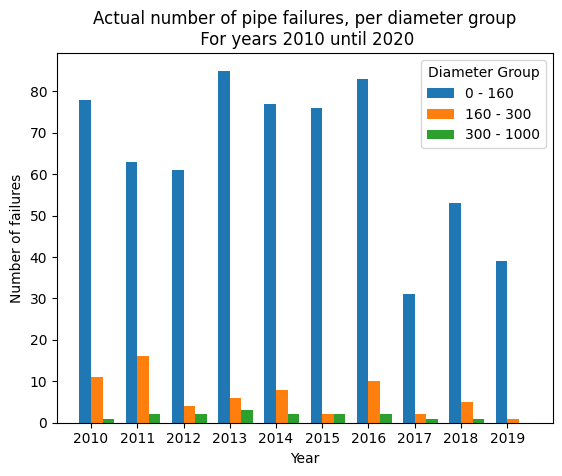

In [31]:
import matplotlib.pyplot as plt

# Assuming failures DataFrame is already defined
failures['number_of_failures'] = 1

# Convert 'storing_melddatum' column to datetime if it's not already
failures['storing_melddatum'] = pd.to_datetime(failures['storing_melddatum'])

# Group by 'Diameter_group' and 'storing_melddatum' year, and count the number of failures
grouped = failures.groupby(['Diameter_group', failures['storing_melddatum'].dt.year])['number_of_failures'].count()

# Reset the index to make all columns accessible
grouped = grouped.reset_index()

# Extract unique 'Diameter_group' values
diameter_groups = grouped['Diameter_group'].unique()

# Set the width of the bars
bar_width = 0.25

# Extract unique years for plotting
years = grouped['storing_melddatum'].unique()

# Plotting
fig, ax = plt.subplots()
failure_counts_dict = {}
# Plot each 'Diameter_group' as a side-by-side bar chart
for i, group in enumerate(diameter_groups):
    group_data = grouped[grouped['Diameter_group'] == group]
    # Create a list of counts for each year, filling in missing years with zeros
    counts = [group_data[group_data['storing_melddatum'] == year]['number_of_failures'].values[0] if year in group_data['storing_melddatum'].values else 0 for year in years]
    failure_counts_dict[group] = counts
    ax.bar([p + i * bar_width for p in range(len(years))], counts, bar_width, label=group)
actual_failures_df = pd.DataFrame(failure_counts_dict, index=failure_counts_df.index)
# Add labels, title, and legend
ax.set_xlabel('Year')
ax.set_ylabel('Number of failures')
ax.set_title('Actual number of pipe failures, per diameter group\n For years 2010 until 2020')
ax.set_xticks([p + 0.5 * bar_width for p in range(len(years))])
ax.set_xticklabels(years)
ax.legend(title='Diameter Group')

plt.show()


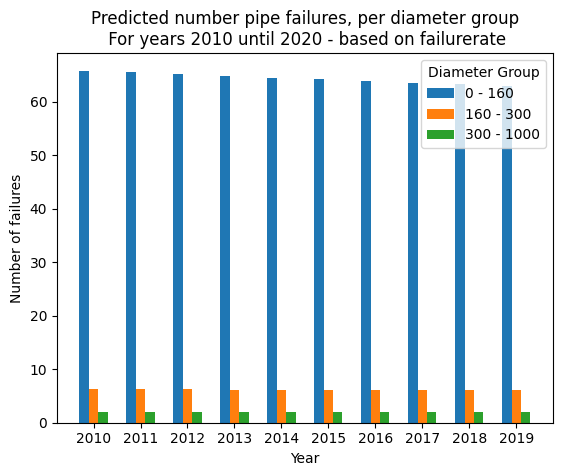

In [32]:
failures = pd.DataFrame()
pipe_length = pipe_train.groupby(pipe_train['Diameter_group'])['Lengte'].sum() / 1000
pipe_length_mean = pipe_train.groupby(pipe_train['Diameter_group'])['Lengte'].mean() / 1000
for year in range(2010, 2020):
    for dia, fail in zip(failure_train.Diameter_group.unique(), failure_train.Diameter_group_failurerate.unique()):
        number_of_failures = pipe_length[dia] * fail
        pipe_length[dia] = pipe_length[dia] -  number_of_failures * pipe_length_mean[dia]
        failures.loc[year, dia] = number_of_failures

df = failures

# Number of bars per group
n_bars = len(df.columns)
# Number of groups (original columns)
n_groups = len(df.index)

# Create a figure and an axis
fig, ax = plt.subplots()

# Bar width
bar_width = 0.2

# Positions of the groups on the x-axis
indices = np.arange(n_groups)

# Plotting the bars
for i, column in enumerate(df.columns):
    bar_positions = indices + i * bar_width
    ax.bar(bar_positions, df[column], bar_width, label=column)

# Set the position of the x ticks
ax.set_xticks(indices + bar_width * (n_bars - 1) / 2)
ax.set_xticklabels(df.index)

# Adding labels and title
ax.set_xlabel('Year')
ax.set_ylabel('Number of failures')
ax.set_title('Predicted number pipe failures, per diameter group\n For years 2010 until 2020 - based on failurerate')
ax.legend(title='Diameter Group')

# Show the plot
plt.show()


In [33]:
# PLOT TO SHOW PERFORMANCE DIFFERENCE BETWEEN MODEL.
relative_error_sc = (failure_counts_df/ actual_failures_df) * 100
relative_error_fr = (df / actual_failures_df) * 100

C:\Users\Jip\AppData\Local\Temp\ipykernel_12696\2697135149.py:38: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout(rect=[0, 0.03, 1, 0.95])


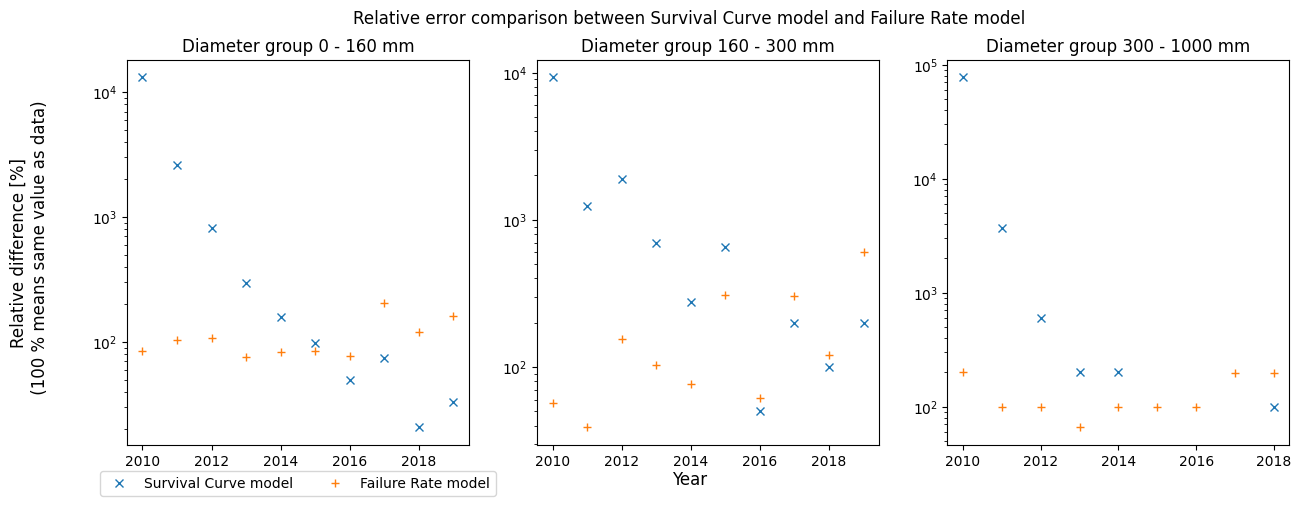

In [34]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))

# Plot for ax1
ax1 = plt.subplot(131)
relative_error_sc['0 - 160'].plot(ls='', marker='x', ax=ax1, label='Survival Curve model')
relative_error_fr['0 - 160'].plot(ls='', marker='+', ax=ax1, label='Failure Rate model')
ax1.set_yscale('log')
ax1.set_title('Diameter group 0 - 160 mm')

# Adding a single legend
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=2)

# Plot for ax2
ax2 = plt.subplot(132)
relative_error_sc['160 - 300'].plot(ls='', marker='x', ax=ax2)
relative_error_fr['160 - 300'].plot(ls='', marker='+', ax=ax2)
ax2.set_yscale('log')
ax2.set_title('Diameter group 160 - 300 mm')

# Plot for ax3
ax3 = plt.subplot(133)
relative_error_sc['300 - 1000'].plot(ls='', marker='x', ax=ax3)
relative_error_fr['300 - 1000'].plot(ls='', marker='+', ax=ax3)
ax3.set_yscale('log')
ax3.set_title('Diameter group 300 - 1000 mm')

# Adding the overall title
plt.suptitle('Relative error comparison between Survival Curve model and Failure Rate model')

# Adding a single x and y label
plt.text(0.5, 0.04, 'Year', ha='center', va='center', fontsize=12, transform=plt.gcf().transFigure)
plt.text(0.06, 0.5, 'Relative difference [%] \n (100 % means same value as data)', ha='center', va='center', rotation='vertical', fontsize=12, transform=plt.gcf().transFigure)



plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()
